In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.utils
import torch.utils.data as Data

from torch.autograd import Variable
import numpy as np
import os


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0,0,0], [1,1,1])
])

test_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor()
])

batch_size = 32

train_data = dsets.ImageFolder('monkey_data/training/', train_transform)
test_data = dsets.ImageFolder('monkey_data/validation/', test_transform)

train_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = Data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)

In [4]:
len(train_data), len(test_data)

(1097, 272)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,25))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(title)
    plt.show()

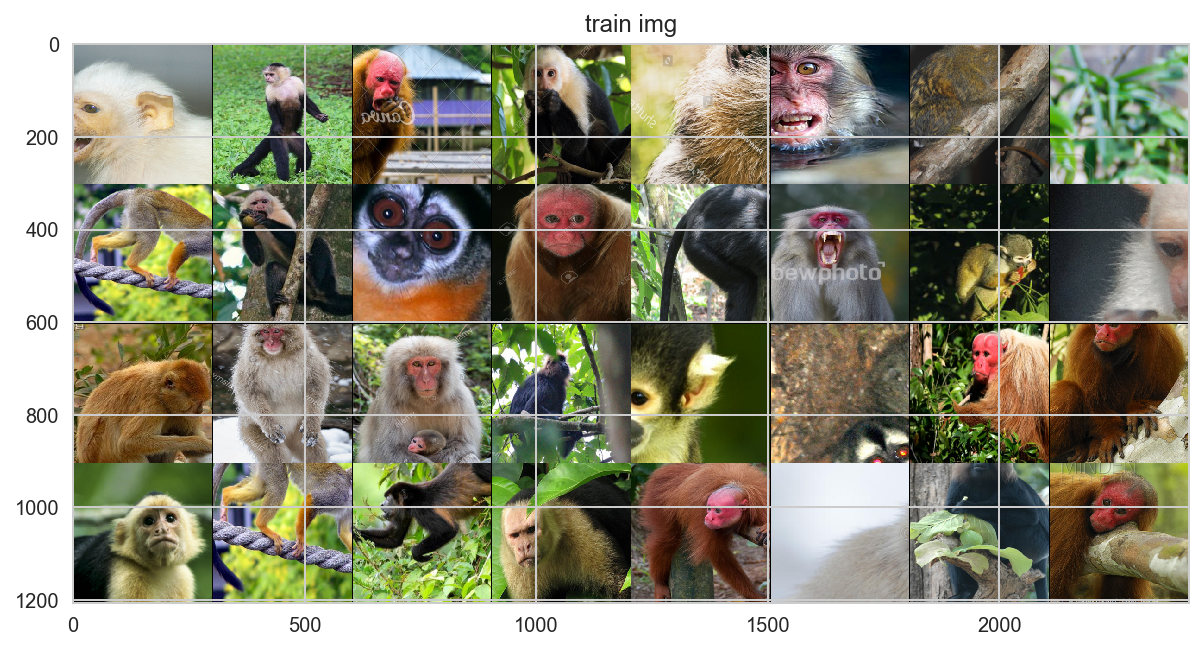

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, normalize=True), 'train img')

In [7]:
model = models.inception_v3(pretrained=True)

model.aux_logits = False

fine_tune = False

if not fine_tune:
    for parameter in model.parameters():
        parameter.requires_grad = False
        
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 100),
    nn.Linear(100, 10),
)

model.cuda()

print('model done')

model done


In [8]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [9]:
num_epochs = 10

In [10]:
loss_ls = []

In [11]:
for epoch in range(num_epochs):
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = Variable(batch_images).cuda()
        Y = Variable(batch_labels).cuda()
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0:
            loss_ls.append(cost.data[0])
            print('EPOCH [%d/%d], Iter [%d/%d] Loss: %.4f'
                 % (epoch+1, num_epochs, i+1, len(train_data)//batch_size, cost.data[0]))

EPOCH [1/10], Iter [5/34] Loss: 2.0386
EPOCH [1/10], Iter [10/34] Loss: 1.8889
EPOCH [1/10], Iter [15/34] Loss: 1.5202
EPOCH [1/10], Iter [20/34] Loss: 1.5387
EPOCH [1/10], Iter [25/34] Loss: 0.9839
EPOCH [1/10], Iter [30/34] Loss: 1.0067
EPOCH [1/10], Iter [35/34] Loss: 0.8728
EPOCH [2/10], Iter [5/34] Loss: 0.6386
EPOCH [2/10], Iter [10/34] Loss: 0.4867
EPOCH [2/10], Iter [15/34] Loss: 0.7141
EPOCH [2/10], Iter [20/34] Loss: 0.5939
EPOCH [2/10], Iter [25/34] Loss: 0.4555
EPOCH [2/10], Iter [30/34] Loss: 0.4771
EPOCH [2/10], Iter [35/34] Loss: 0.5257
EPOCH [3/10], Iter [5/34] Loss: 0.5587
EPOCH [3/10], Iter [10/34] Loss: 0.6656
EPOCH [3/10], Iter [15/34] Loss: 0.3024
EPOCH [3/10], Iter [20/34] Loss: 0.4809
EPOCH [3/10], Iter [25/34] Loss: 0.4517
EPOCH [3/10], Iter [30/34] Loss: 0.3003
EPOCH [3/10], Iter [35/34] Loss: 0.2429
EPOCH [4/10], Iter [5/34] Loss: 0.4188
EPOCH [4/10], Iter [10/34] Loss: 0.5592
EPOCH [4/10], Iter [15/34] Loss: 0.5651
EPOCH [4/10], Iter [20/34] Loss: 0.5166
EPOC

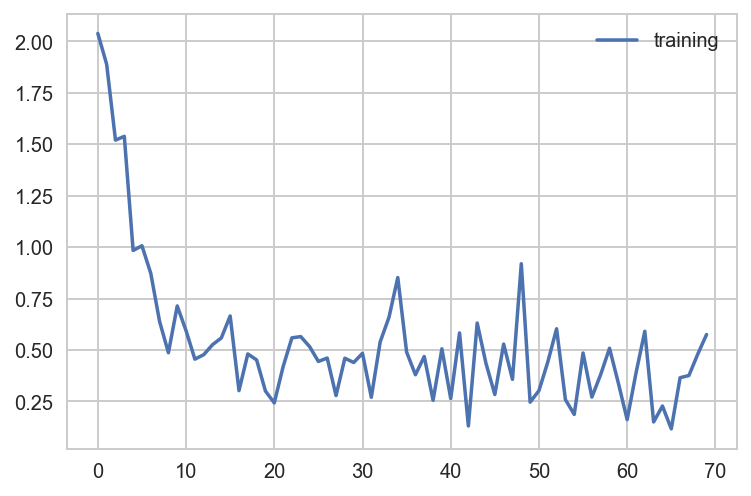

In [12]:
plt.plot(loss_ls, 'b-', label="training")
plt.legend()
plt.show()

In [13]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    images = Variable(images).cuda()
    output = model(images)
    
    _, predicted = torch.max(output.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('ACC : %f %%' % (100 * correct / total))

ACC : 97.794118 %


In [14]:
classes = tuple(train_data.classes)

In [15]:
print('classes : %d \n ' % len(classes), train_data.classes)

classes : 10 
  ['alouatta_palliata', 'aotus_nigriceps', 'cacajao_calvus', 'cebuella_pygmea', 'cebus_capucinus', 'erythrocebus_patas', 'macaca_fuscata', 'mico_argentatus', 'saimiri_sciureus', 'trachypithecus_johnii']


Predicted:  mico_argentatus /  saimiri_sciureus /  aotus_nigriceps /  trachypithecus_johnii /  cacajao_calvus / 


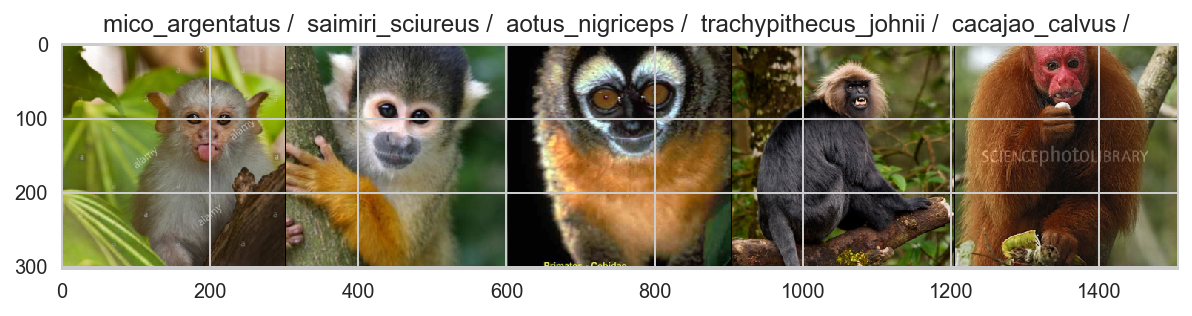

In [19]:
images, labels = iter(test_loader).next()

outputs = model(Variable(images).cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s / ' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s / ' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images[:5], normalize=True), title)